# Task 2: Baseline CNN & SHAP

In [28]:
import matplotlib.pyplot as plt
from data import get_img_dataset
from torchvision import transforms
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from model import BaselineClf
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
import tqdm
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from project3Lib.transforms import EnhanceContrast

from torchvision.datasets import ImageFolder


In [83]:
# load data and transform data if augmentation == yes
augmentation = input("Use augmentation? [yes/no]").lower() == "yes"

unique = input("Use unique images?[yes/no]").lower() == "yes"
input_path = "data/unique_images" if unique else "data/images"

if augmentation:
    transform = [EnhanceContrast(reduce_dim=False)]
    train_dataset,val_dataset, test_dataset = get_img_dataset(transform, data_path=input_path, use_same_transforms = True)
    #train_dataset2, val_dataset, test_dataset = get_img_dataset(transform,data_path=input_path, use_same_transforms = True)
    #train_dataset = ConcatDataset([train_dataset,train_dataset] )
    
    model_file_path = "baselineCNN_augmented_unique" if unique else "baselineCNN_augmented"
    
else: 
    train_dataset, val_dataset, test_dataset = get_img_dataset(data_path=input_path)
    
    model_file_path = "baselineCNN_unique" if unique else "baselineCNN"

Use augmentation? [yes/no]yes
Use unique images?[yes/no]yes
Loaded samples into dataset with label 'no'=0 and 'yes'=1


In [84]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(f"Class sizes{np.unique([y for x,y in train_dataset], return_counts = True)}")

Device state: cpu
Class sizes(array([0, 1]), array([71, 87]))


In [62]:
print_statements = False 
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    acc_total = 0

    # Test validation data
    with torch.no_grad():
        for data in valid_loader:
            input = data[0].to(device)
            label = data[1].to(device)
            
            res = model.validation_step(data)
            loss = res['val_loss']
            loss_total += loss
            
            acc = res['val_acc']
            acc_total += acc
            
    return loss_total / len(valid_loader), acc_total/ len(valid_loader)

# Train
def traindata(device, model, epochs, optimizer, loss_function, train_loader, valid_loader, patience):
    # Early stopping
    last_loss = 200
    patience = patience
    triggertimes = 0
    
    for epoch in tqdm.tqdm(range(1, epochs+1)):
        model.train()

        for times, data in enumerate(train_loader, 1):

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            loss = model.training_step(data)
            loss.backward()
            optimizer.step()

            # Show progress
            if times % 100 == 0 or times == len(train_loader):
                if(print_statements): print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, times, len(train_loader), loss.item()))

        # Early stopping
        current_loss, current_acc = validation(model, device, valid_loader, loss_function)
        if(print_statements): print('The Current Loss:', current_loss, "The Current Acc:", current_acc)

        if current_loss > last_loss:
            trigger_times += 1
            if(print_statements): print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                if(print_statements): print('Early stopping!\nStart to test process.')
                return best_model

        else:
            if(print_statements): print('trigger times: 0')
            trigger_times = 0
            best_model = model

        last_loss = current_loss

    return model

def test(device, model, testloader):
    loss_total = 0
    acc_total = 0

    # Test validation data
    with torch.no_grad():
        model.eval()
        for data in testloader:
            input = data[0].to(device)
            label = data[1].to(device)

            res = model.validation_step(data)
            loss = res['val_loss']
            loss_total += loss

            acc = res['val_acc']
            acc_total += acc
    acc = acc_total/len(testloader)
    loss = loss_total/len(testloader)
    
    return acc, loss

def predict(model, x):
    out = model(x.reshape(1, 3, 128, 128))   
    _,prediction = torch.max(out, dim=1)
    return prediction[0].item(), out

## Hyperparameters

In [188]:
# hyperparameters
parameters = {
    "lr": [0.005, 0.001,0.0005,0.0001],
    "optimizers": ["SGD", "Adam", "RMSprop"]
}

results = {}

epochs = 150
for opt in parameters["optimizers"]:
    for lr in parameters["lr"]:
        model = BaselineClf()
        criterion = CrossEntropyLoss()

        if opt == "SGD":
            optimizer = SGD(model.parameters(), lr=lr)
        elif opt == "Adam":
            optimizer = Adam(model.parameters(), lr=lr)
        else:
            optimizer = RMSprop(model.parameters(), lr=lr)

        model = traindata(device, model, epochs, optimizer, criterion, trainloader, validloader, 3)

        val_acc, val_loss = test(device, model, validloader)

        results[f"{opt}_{lr}"] = (val_acc, val_loss)
        print(f"{opt}_{lr} - acc: {val_acc} - loss: {val_loss}")
    

 17%|██████████▏                                                | 26/150 [04:02<19:16,  9.33s/it]


SGD_0.005 - acc: 0.5625 - loss: 0.7009416222572327


  2%|█▏                                                          | 3/150 [00:27<22:17,  9.10s/it]

KeyboardInterrupt



In [203]:
results

{'SGD_0.005': (0.9270833333333333, tensor(0.4027)),
 'SGD_0.001': (0.8229166666666667, tensor(0.4827)),
 'SGD_0.0005': (0.8541666666666667, tensor(0.5051)),
 'SGD_0.0001': (0.8229166666666667, tensor(0.5432)),
 'Adam_0.005': (0.8854166666666667, tensor(0.4224)),
 'Adam_0.001': (0.96875, tensor(0.3527)),
 'Adam_0.0005': (0.90625, tensor(0.3788)),
 'Adam_0.0001': (0.9583333333333333, tensor(0.4041)),
 'RMSprop_0.005': (0.8125, tensor(0.4896)),
 'RMSprop_0.001': (0.8125, tensor(0.4622)),
 'RMSprop_0.0005': (0.8645833333333333, tensor(0.4464)),
 'RMSprop_0.0001': (0.96875, tensor(0.3540))}

Optimal hyperparameters for standard dataset: 
{'SGD_0.005': (0.9270833333333333, tensor(0.4027)),
 'SGD_0.001': (0.8229166666666667, tensor(0.4827)),
 'SGD_0.0005': (0.8541666666666667, tensor(0.5051)),
 'SGD_0.0001': (0.8229166666666667, tensor(0.5432)),
 'Adam_0.005': (0.8854166666666667, tensor(0.4224)),
 'Adam_0.001': (0.96875, tensor(0.3527)),
 'Adam_0.0005': (0.90625, tensor(0.3788)),
 'Adam_0.0001': (0.9583333333333333, tensor(0.4041)),
 'RMSprop_0.005': (0.8125, tensor(0.4896)),
 'RMSprop_0.001': (0.8125, tensor(0.4622)),
 'RMSprop_0.0005': (0.8645833333333333, tensor(0.4464)),
 'RMSprop_0.0001': (0.96875, tensor(0.3540))}
 
 
 Optimal hyperparameters for augmented dataset:

# Train final model

In [86]:
print_statements = True

model = BaselineClf()
criterion = CrossEntropyLoss()

if augmentation:
    optimizer = Adam(model.parameters(), lr=0.00005)
else:
    optimizer = Adam(model.parameters(), lr=0.0005)

epochs = 30
model = traindata(device, model, epochs, optimizer, criterion, trainloader, validloader, 4)
torch.save(model.state_dict(), f"{model_file_path}_fancytransform.pt")

  0%|                                                                     | 0/30 [00:00<?, ?it/s]

[1/30, 10/10] loss: 0.65488374


  3%|██                                                           | 1/30 [00:02<01:08,  2.37s/it]

The Current Loss: tensor(0.6914) The Current Acc: 0.75
trigger times: 0
[2/30, 10/10] loss: 0.54434109
The Current Loss: 

  7%|████                                                         | 2/30 [00:04<01:05,  2.35s/it]

tensor(0.6861) The Current Acc: 0.5625
trigger times: 0
[3/30, 10/10] loss: 0.46367005


 10%|██████                                                       | 3/30 [00:07<01:03,  2.35s/it]

The Current Loss: tensor(0.6626) The Current Acc: 0.65625
trigger times: 0
[4/30, 10/10] loss: 0.43363848
The Current Loss: 

 13%|████████▏                                                    | 4/30 [00:09<01:01,  2.36s/it]

tensor(0.6120) The Current Acc: 0.75
trigger times: 0
[5/30, 10/10] loss: 0.39867061
The Current Loss: 

 17%|██████████▏                                                  | 5/30 [00:11<01:00,  2.40s/it]

tensor(0.6990) The Current Acc: 0.59375
Trigger Times: 1
[6/30, 10/10] loss: 0.38781267


 20%|████████████▏                                                | 6/30 [00:14<00:57,  2.41s/it]

The Current Loss: tensor(0.6389) The Current Acc: 0.8125
trigger times: 0
[7/30, 10/10] loss: 0.39515319


 23%|██████████████▏                                              | 7/30 [00:16<00:55,  2.40s/it]

The Current Loss: tensor(0.6549) The Current Acc: 0.5625
Trigger Times: 1
[8/30, 10/10] loss: 0.37496376
The Current Loss: 

 27%|████████████████▎                                            | 8/30 [00:19<00:52,  2.39s/it]

tensor(0.7005) The Current Acc: 0.5625
Trigger Times: 2
[9/30, 10/10] loss: 0.37127966


 30%|██████████████████▎                                          | 9/30 [00:21<00:50,  2.41s/it]

The Current Loss: tensor(0.7250) The Current Acc: 0.59375
Trigger Times: 3
[10/30, 10/10] loss: 0.36160022


 33%|████████████████████                                        | 10/30 [00:23<00:48,  2.41s/it]

The Current Loss: tensor(0.6614) The Current Acc: 0.6875
trigger times: 0
[11/30, 10/10] loss: 0.37116668


 37%|██████████████████████                                      | 11/30 [00:26<00:45,  2.42s/it]

The Current Loss: tensor(0.6832) The Current Acc: 0.6875
Trigger Times: 1
[12/30, 10/10] loss: 0.36032149


 40%|████████████████████████                                    | 12/30 [00:28<00:43,  2.41s/it]

The Current Loss: tensor(0.6643) The Current Acc: 0.65625
trigger times: 0


 43%|██████████████████████████                                  | 13/30 [00:31<00:40,  2.41s/it]

[13/30, 10/10] loss: 0.37438035
The Current Loss: tensor(0.7062) The Current Acc: 0.5625
Trigger Times: 1


 47%|████████████████████████████                                | 14/30 [00:33<00:38,  2.40s/it]

[14/30, 10/10] loss: 0.3731181
The Current Loss: tensor(0.6357) The Current Acc: 0.65625
trigger times: 0
[15/30, 10/10] loss: 0.37383771


 50%|██████████████████████████████                              | 15/30 [00:35<00:35,  2.39s/it]

The Current Loss: tensor(0.6937) The Current Acc: 0.5625
Trigger Times: 1
[16/30, 10/10] loss: 0.37270418


 53%|████████████████████████████████                            | 16/30 [00:38<00:33,  2.40s/it]

The Current Loss: tensor(0.6581) The Current Acc: 0.65625
trigger times: 0
[17/30, 10/10] loss: 0.35406366


 57%|██████████████████████████████████                          | 17/30 [00:40<00:31,  2.41s/it]

The Current Loss: tensor(0.6759) The Current Acc: 0.5625
Trigger Times: 1
[18/30, 10/10] loss: 0.37855777


 60%|████████████████████████████████████                        | 18/30 [00:43<00:28,  2.41s/it]

The Current Loss: tensor(0.6904) The Current Acc: 0.5625
Trigger Times: 2
[19/30, 10/10] loss: 0.35335985


 63%|██████████████████████████████████████                      | 19/30 [00:45<00:27,  2.46s/it]

The Current Loss: tensor(0.6596) The Current Acc: 0.65625
trigger times: 0


 67%|████████████████████████████████████████                    | 20/30 [00:48<00:24,  2.44s/it]

[20/30, 10/10] loss: 0.36254224
The Current Loss: tensor(0.6510) The Current Acc: 0.65625
trigger times: 0


 70%|██████████████████████████████████████████                  | 21/30 [00:50<00:21,  2.42s/it]

[21/30, 10/10] loss: 0.39518613
The Current Loss: tensor(0.7223) The Current Acc: 0.5
Trigger Times: 1
[22/30, 10/10] loss: 0.34721732


 73%|████████████████████████████████████████████                | 22/30 [00:52<00:19,  2.39s/it]

The Current Loss: tensor(0.6955) The Current Acc: 0.53125
trigger times: 0
[23/30, 10/10] loss: 0.34725851


 77%|██████████████████████████████████████████████              | 23/30 [00:55<00:16,  2.38s/it]

The Current Loss: tensor(0.6338) The Current Acc: 0.65625
trigger times: 0
[24/30, 10/10] loss: 0.35791963


 80%|████████████████████████████████████████████████            | 24/30 [00:57<00:14,  2.41s/it]

The Current Loss: tensor(0.7161) The Current Acc: 0.4375
Trigger Times: 1
[25/30, 10/10] loss: 0.35494319


 83%|██████████████████████████████████████████████████          | 25/30 [01:00<00:12,  2.41s/it]

The Current Loss: tensor(0.6027) The Current Acc: 0.71875
trigger times: 0
[26/30, 10/10] loss: 0.34703881


 87%|████████████████████████████████████████████████████        | 26/30 [01:02<00:09,  2.41s/it]

The Current Loss: tensor(0.6259) The Current Acc: 0.65625
Trigger Times: 1
[27/30, 10/10] loss: 0.35917565
The Current Loss: 

 90%|██████████████████████████████████████████████████████      | 27/30 [01:04<00:07,  2.41s/it]

tensor(0.5891) The Current Acc: 0.75
trigger times: 0
[28/30, 10/10] loss: 0.34345049
The Current Loss: 

 93%|████████████████████████████████████████████████████████    | 28/30 [01:07<00:04,  2.39s/it]

tensor(0.6351) The Current Acc: 0.65625
Trigger Times: 1


 97%|██████████████████████████████████████████████████████████  | 29/30 [01:09<00:02,  2.38s/it]

[29/30, 10/10] loss: 0.35436895
The Current Loss: tensor(0.6644) The Current Acc: 0.5625
Trigger Times: 2


100%|████████████████████████████████████████████████████████████| 30/30 [01:11<00:00,  2.40s/it]

[30/30, 10/10] loss: 0.36603084
The Current Loss: tensor(0.6836) The Current Acc: 0.4375
Trigger Times: 3


In [87]:
x_test = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]
preds = []
outs = []
for t in x_test:
    pred, out = predict(model, t)
    preds.append(pred)
    
print(f"Accuracy: {accuracy_score(preds,y_test)}")
print(f"F1 score: {f1_score(preds,y_test)}")

Accuracy: 0.7
F1 score: 0.7000000000000001


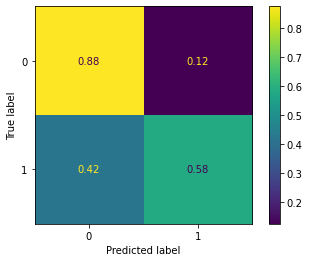

In [88]:
cm=confusion_matrix(y_test,preds,normalize="true")
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

Baseline performance (no augmentation):
```
Accuracy: 0.8928571428571429
F1 score: 0.918918918918919
```
![](Plots/CM_BaselineCNN_NoAugmentation.png)

Baseline performance (unique values):
```
Accuracy: 0.75
F1 score: 0.761904761904762
```
![](Plots/CM_BaselineUniqueNoAugmentation.png)


Baseline performance (with augmentation): 

```
Accuracy: 0.8928571428571429
F1 score: 0.918918918918919
```

## SHAP analysis

In [69]:
model = BaselineClf()
model.load_state_dict(torch.load(f"{model_file_path}.pt"))
model.eval()

BaselineClf(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Re

In [47]:
import shap
import numpy as np

In [75]:
def get_only_oneclass(target, dataset):
    return [(i,j) for i,j in dataset if j == target]

Mean values 0.45584999126252496, 0.5441500093269197


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Image #0: True Class 1, Prediction 1, Probabilities tensor([[0.2100, 0.7900]], grad_fn=<SoftmaxBackward0>)


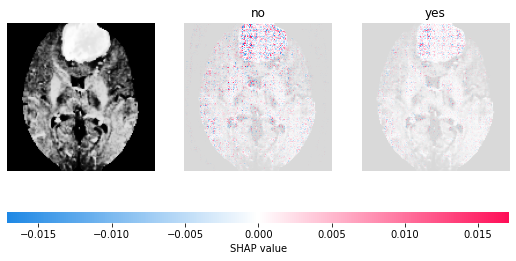

Image #1: True Class 0, Prediction 0, Probabilities tensor([[0.8745, 0.1255]], grad_fn=<SoftmaxBackward0>)


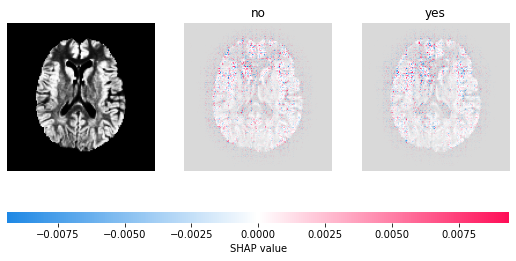

Image #2: True Class 1, Prediction 0, Probabilities tensor([[0.5455, 0.4545]], grad_fn=<SoftmaxBackward0>)


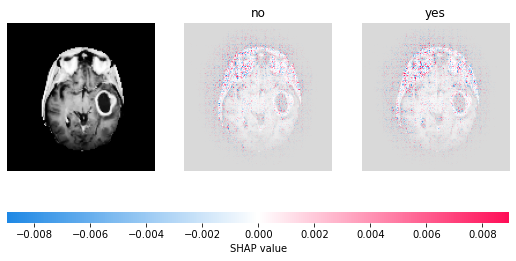

Image #3: True Class 1, Prediction 0, Probabilities tensor([[0.7523, 0.2477]], grad_fn=<SoftmaxBackward0>)


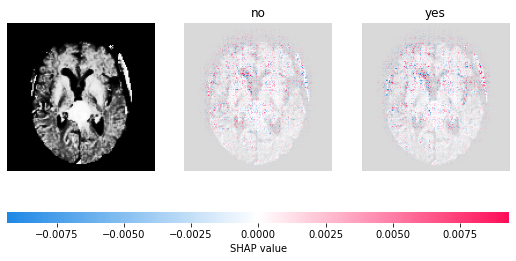

Image #4: True Class 0, Prediction 0, Probabilities tensor([[0.7224, 0.2776]], grad_fn=<SoftmaxBackward0>)


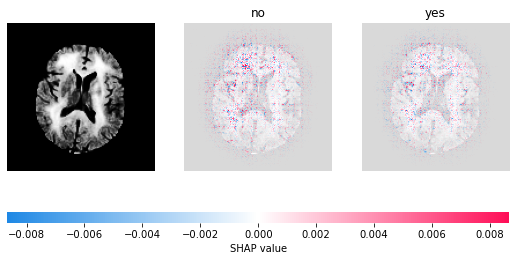

Image #5: True Class 1, Prediction 0, Probabilities tensor([[0.6196, 0.3804]], grad_fn=<SoftmaxBackward0>)


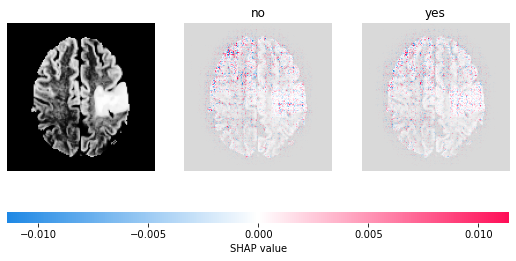

Image #6: True Class 1, Prediction 1, Probabilities tensor([[0.3681, 0.6319]], grad_fn=<SoftmaxBackward0>)


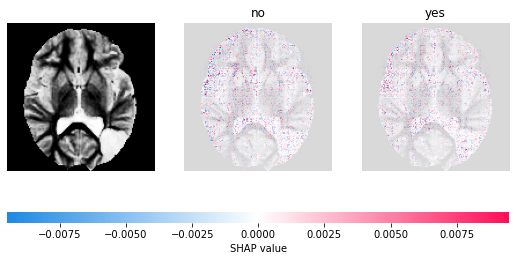

Image #7: True Class 1, Prediction 0, Probabilities tensor([[0.5952, 0.4048]], grad_fn=<SoftmaxBackward0>)


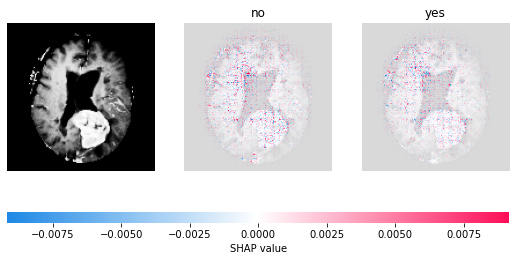

Image #8: True Class 1, Prediction 1, Probabilities tensor([[0.1201, 0.8799]], grad_fn=<SoftmaxBackward0>)


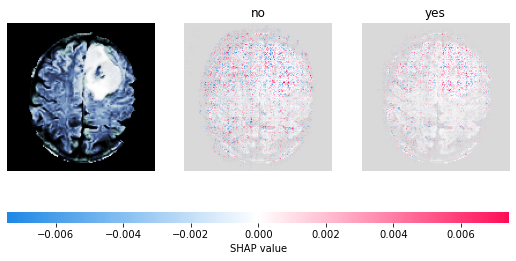

Image #9: True Class 1, Prediction 1, Probabilities tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward0>)


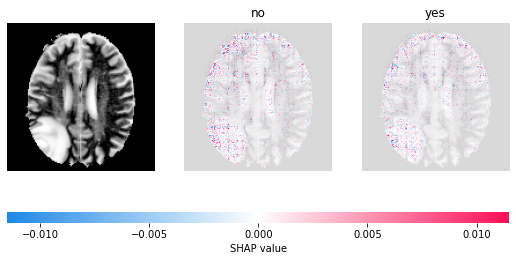

Image #10: True Class 1, Prediction 0, Probabilities tensor([[0.5943, 0.4057]], grad_fn=<SoftmaxBackward0>)


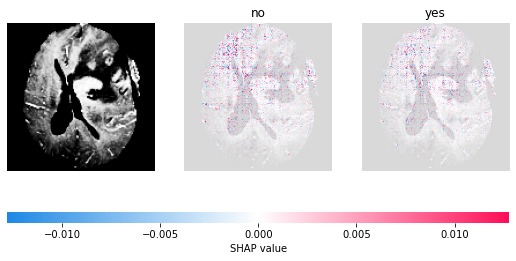

Image #11: True Class 0, Prediction 1, Probabilities tensor([[0.4000, 0.6000]], grad_fn=<SoftmaxBackward0>)


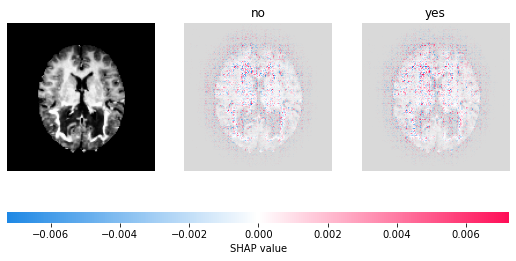

Image #12: True Class 0, Prediction 0, Probabilities tensor([[0.5070, 0.4930]], grad_fn=<SoftmaxBackward0>)


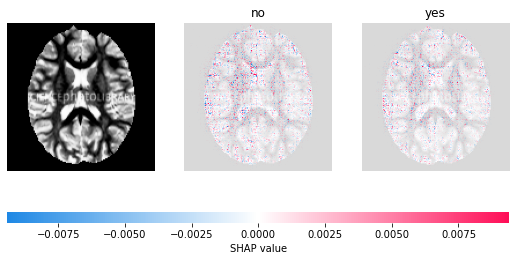

Image #13: True Class 1, Prediction 1, Probabilities tensor([[0.1006, 0.8994]], grad_fn=<SoftmaxBackward0>)


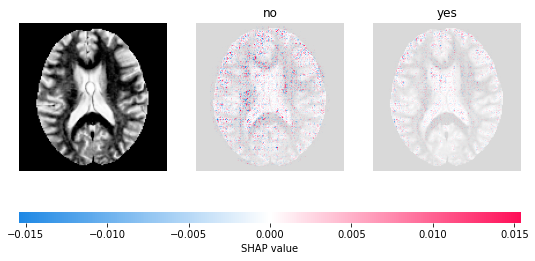

Image #14: True Class 1, Prediction 1, Probabilities tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward0>)


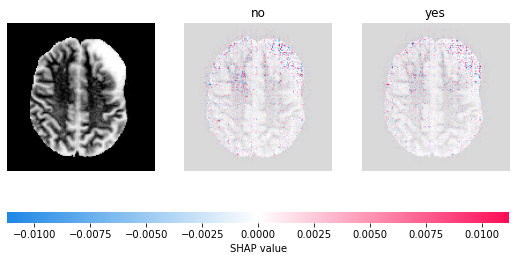

Image #15: True Class 0, Prediction 0, Probabilities tensor([[0.6588, 0.3412]], grad_fn=<SoftmaxBackward0>)


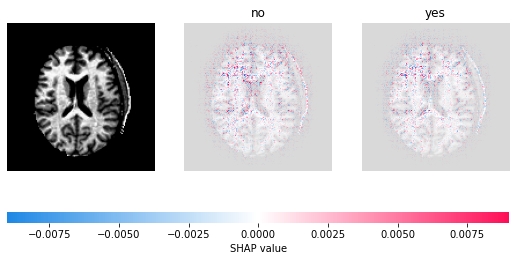

Image #16: True Class 1, Prediction 1, Probabilities tensor([[0.4117, 0.5883]], grad_fn=<SoftmaxBackward0>)


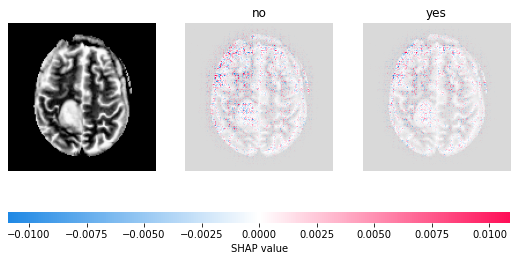

Image #17: True Class 0, Prediction 0, Probabilities tensor([[0.8029, 0.1971]], grad_fn=<SoftmaxBackward0>)


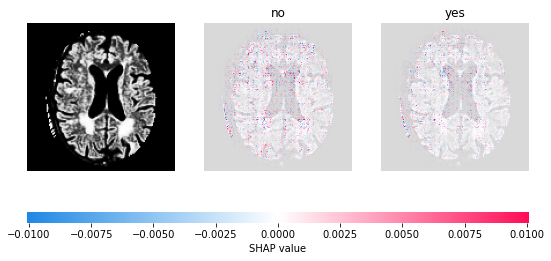

Image #18: True Class 0, Prediction 0, Probabilities tensor([[0.7774, 0.2226]], grad_fn=<SoftmaxBackward0>)


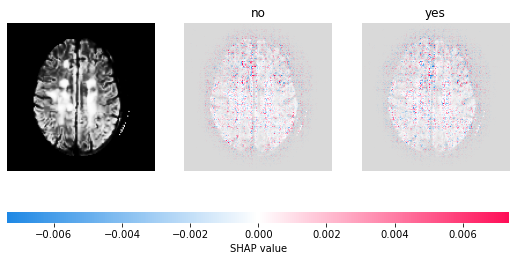

Image #19: True Class 0, Prediction 0, Probabilities tensor([[0.7258, 0.2742]], grad_fn=<SoftmaxBackward0>)


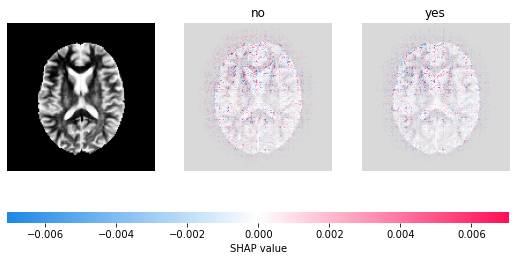

In [89]:
# Deep Explainer
bg = [i for i,j in train_dataset]


#zeroclass = get_only_oneclass(0,train_dataset)
#bg = [i for i,j in zeroclass]
bg = torch.stack(bg)
e = shap.DeepExplainer(model, bg)

outs = []
for i in bg:
    pred, out = predict(model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")

test_images = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]

for i, image in enumerate(test_images):
    
    image = image.reshape((1,3,128,128))
    pred, out = predict(model,image)
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {y_test[i]}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

Image # 0: True Class 1, Prediction 1, Probabilities tensor([[0.0277, 0.9723]], grad_fn=<SoftmaxBackward0>)


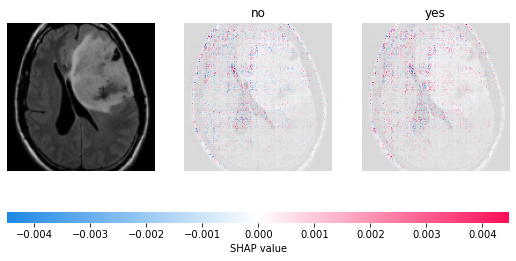

In [106]:
index = 0
image = test_dataset[index][0]
image = image.reshape((1,3,128,128))
pred, out = predict(model,image)
shap_values = e.shap_values(image)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
print(f"Image # {i}: True Class {y_test[i]}, Prediction {pred}, Probabilities {out}")
shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

## Interpretation of SHAP Values etc.

- 123
- 123

In [59]:
# partition explainer/ Not needed


# python function to get model output; replace this function with your own model function.
def f(x):
    helper = torch.from_numpy(x)
    out=model(helper)
    print(out)
    return out.detach().numpy()

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", (3,128,128))

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=[0,1])

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values

num = [i.numpy() for i in test_images]
shap_values = explainer(num, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

tensor([[0.0313, 0.9687]], grad_fn=<SoftmaxBackward0>)


error: OpenCV(4.5.5) /Users/runner/miniforge3/conda-bld/libopencv_1650899568161/work/modules/photo/src/inpaint.cpp:768: error: (-210:Unsupported format or combination of formats) 8-bit, 16-bit unsigned or 32-bit float 1-channel and 8-bit 3-channel input/output images are supported in function 'icvInpaint'
